In [1]:
import pandas as pd
from functions import calc, retrieve, visualize as viz

import warnings
warnings.filterwarnings('ignore')


In [2]:
def retrieveData(fromCSV=False, numberOfStocks=50, daysSince=30, QUICK_EMA_PERIOD=7, SLOW_EMA_PERIOD=14, latestWindow=2):
    if (fromCSV == True):
        print ("Returning stored data.")
        (rawdata, spreads) = ((pd.read_csv('data/close.csv')).set_index('Date'), (pd.read_csv('data/spreads.csv')).set_index('Date'))
    else:
        downloadedData = retrieve.init(fromCSV, numberOfStocks, daysSince)
        rawdata = downloadedData['Close']
        spreads = (downloadedData['High'] - downloadedData['Low'])/(downloadedData['Close'])
        rawdata.to_csv('./data/close.csv')
        spreads.to_csv('./data/spreads.csv')

    companies = rawdata.columns.values

    EMA_df = calc.get_EMA_df(QUICK_EMA_PERIOD, SLOW_EMA_PERIOD, rawdata)
    keyStats = calc.get_intersection_point(EMA_df, rawdata)
    (keyStats['avgRatio'], keyStats['MinAbsRatio']) = calc.ratioWrapper(EMA_df, companies, keyStats)
    keyStats['latestGrowth'] = round(rawdata.pct_change()[-latestWindow:].min(),5)
    keyStats['ratioContr'] = calc.get_stocks_growing_now(rawdata, keyStats, 3)
    return (rawdata, EMA_df, keyStats, spreads)

In [3]:
def showData(rawdata, EMA_df, keyStats, filterSet):
    filteredCompanies = viz.filter_companies(keyStats, filterSet)
    filteredCompanies.to_csv("./logs/filteredCompanies_" + pd.to_datetime('today').strftime('%Y%m%d')) 
    viz.plot_all(rawdata, EMA_df, filteredCompanies, limit=20)

Returning stored data.
EMA Dataframe calculated.
Intersection points found.
Absolute and Relative Mins calculated.
Main companies filtered. 8 outstanding companies.
Displaying 8 first companies
Company ON


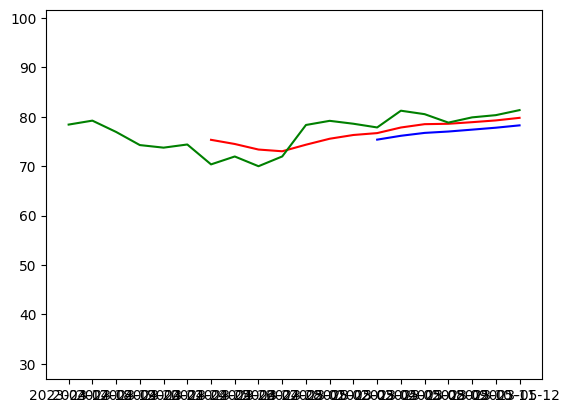

Company MKC


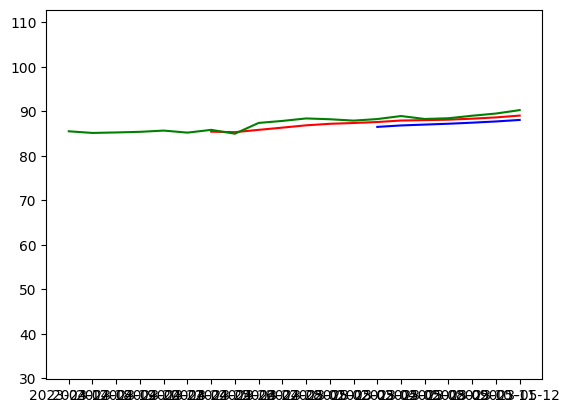

Company STE


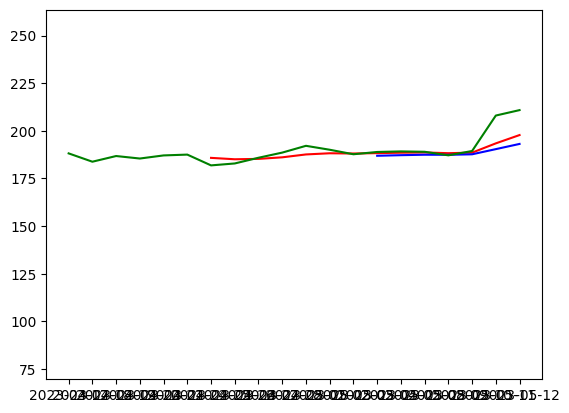

Company GOOGL


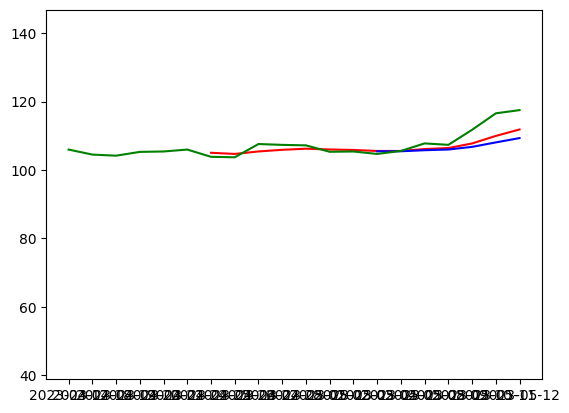

Company GOOG


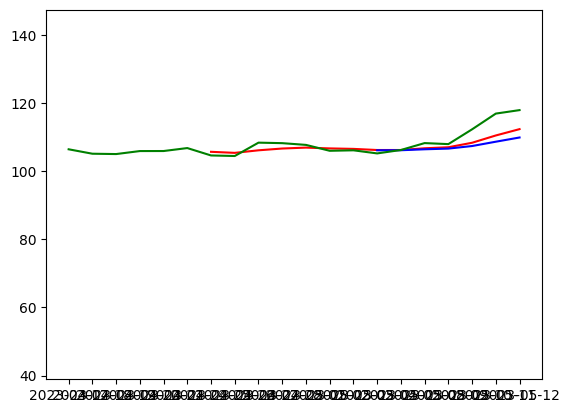

Company DLTR


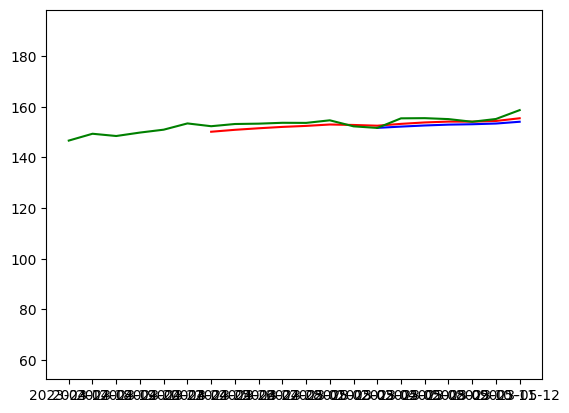

Company LW


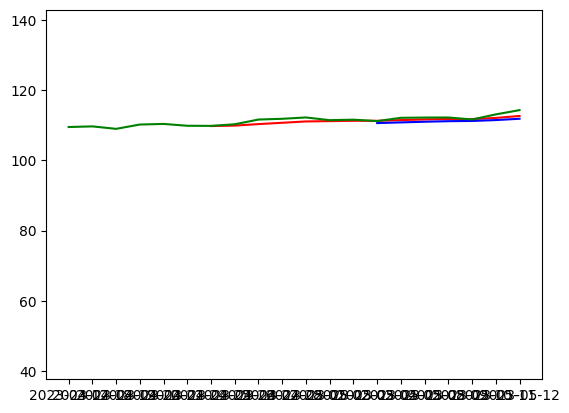

Company CPRT


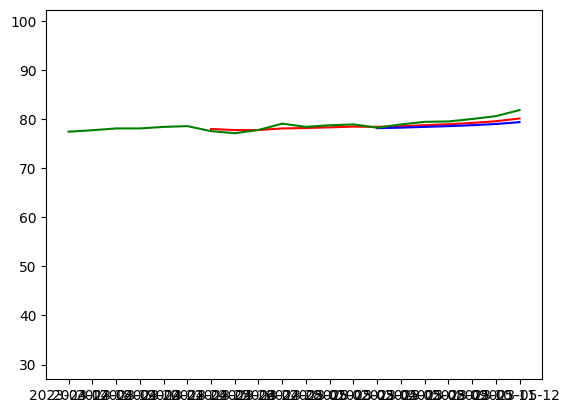

In [4]:
"""
Filterset Sample. Use 0 or comment for Neutral

filterSet = dict({
    "aboveAvgRatio":1, 
    "aboveMinAbs":1, 
    "minPositivePeriod":4, 
    "ratioContr":1, 
    "latestGrowth":0.8
    })

timeframes dict({
    daysSince,
    qema_period,
    sema_period
    }) 
"""

filterSet = dict({
    #"aboveAvgRatio":0.02, 
    "aboveMinAbs":0.0001, 
    #"minPositivePeriod":4, 
    #"ratioContr":1,
    "latestGrowth":0.005
     })

def run_application():
    #(fromCSV, numberOfStocks, timeframes:{daysSince, qema_period, sema_period}, filters: {aboveAvgRatio, aboveMinAbs, aboveRatioContr})
    (rawdata, EMA_df, keyStats, spreads)= retrieveData(fromCSV=True, numberOfStocks=500)
    showData(rawdata, EMA_df, keyStats, filterSet)
    return (rawdata, EMA_df, keyStats, spreads)

(rawdata, EMA_df, keyStats, spreads) = run_application()



In [5]:
keyStats.loc['ROST']

Turning point       0.00000
Turning value     104.51000
Value now         104.51000
Percent Growth      0.00000
avgRatio           -0.00000
MinAbsRatio        -0.00000
latestGrowth        0.00569
ratioContr          3.57043
Name: ROST, dtype: float64

In [6]:
rawdata['STE'].tail()

Date
2023-05-08    188.979996
2023-05-09    187.119995
2023-05-10    189.389999
2023-05-11    208.000000
2023-05-12    210.850006
Name: STE, dtype: float64

In [7]:
import pandas as pd
from functions import calc, retrieve, visualize as viz

import warnings
warnings.filterwarnings('ignore')



In [8]:
(closeData, spreads) = retrieve.init(fromCSV=False, numberOfStocks=10, daysSince=30)
spreads.head()

Requested days: 30.
Requested stocks: 10.
[*********************100%***********************]  10 of 10 completed


ValueError: too many values to unpack (expected 2)